<a href="https://colab.research.google.com/github/rahul5857/AI-Based-Crop-Health-Monitoring-Using-Multispectral-Data/blob/main/Crop_Health_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AI-Based Crop Health Monitoring Using Multispectral Data
##  Capstone Project
### Objective
Build an AI model to detect crop stress using vegetation indices derived from drone multispectral analysis. The system predicts stress levels, evaluates model performance, and generates field-level stress visualizations for drone decision-making.

### Why This Problem Matters
Crop stress reduces yield and is often not visible early to the human eye. Multispectral drone indices such as NDVI and moisture index help detect stress earlier. AI models can learn patterns across these indices and automatically classify stressed regions for faster intervention.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Task 1 - Data Understanding
The dataset contains vegetation indices such as NDVI, GNDVI, SAVI, EVI, moisture index, and canopy density. Each row represents a spatial crop observation derived from drone multispectral analysis.

### Vegetation indices meaning
NDVI measures plant greenness.
GNDVI indicates chlorophyll content.
SAVI adjusts vegetation index for soil brightness.
EVI improves vegetation signal in dense canopy.
Moisture index reflects plant water stress.
Canopy density shows vegetation coverage.

In [ ]:
df = pd.read_excel("/content/Synthetic Multispectral Crops Data.xlsx")
df.head(10)

,ndvi_mean,ndvi_std,ndvi_min,ndvi_max,gndvi,savi,evi,red_edge_1,red_edge_2,nir_reflectance,soil_brightness,canopy_density,moisture_index,grid_x,grid_y,crop_health_label
0,0.462178,0.118574,0.345162,0.527650,0.434070,0.493184,0.426272,0.538210,0.387860,0.715725,0.531091,0.586647,0.679785,9,0,Healthy
1,0.865500,0.023196,0.814436,1.056953,0.855039,0.887622,0.807505,0.200828,0.391693,0.350926,0.304631,0.418664,0.926373,4,8,Healthy
2,0.712396,0.022876,0.539486,0.881657,0.628224,0.721757,0.708308,0.139121,0.474993,0.479509,0.394532,0.829622,0.443202,6,7,Healthy
3,0.619061,0.062069,0.515087,0.696248,0.578767,0.609120,0.640899,0.494059,0.354945,0.555526,0.594686,0.882743,0.788671,4,5,Healthy
4,0.309213,0.083524,0.178098,0.466014,0.357456,0.357234,0.434805,0.517743,0.152411,0.767144,0.781283,0.916408,0.637918,14,19,Healthy
5,0.309196,0.120153,0.157601,0.416940,0.389975,0.314811,0.218483,0.181326,0.529146,0.787385,0.725197,0.724782,0.934311,18,17,Healthy
6,0.240659,0.108828,0.085264,0.351003,0.178941,0.161976,0.310221,0.527173,0.254882,0.836803,0.339703,0.902510,0.458540,9,15,Stressed
7,0.806323,0.077967,0.612926,0.973817,0.776700,0.761636,0.864709,0.443384,0.585649,0.556472,0.798739,0.310790,0.387186,7,7,Healthy
8,0.620781,0.055571,0.491080,0.815198,0.619460,0.613347,0.574035,0.360041,0.158930,0.685992,0.102453,0.375065,0.898428,8,3,Healthy
9,0.695651,0.149626,0.585693,0.764649,0.709659,0.708051,0.707845,0.515125,0.579126,0.278260,0.119341,0.364803,0.144320,10,2,Stressed


In [ ]:
print("Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nMissing values:", df.isnull().sum())
print("\nSummary stats:", df.describe())

Shape: (1200, 16)

Columns: Index(['ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'gndvi', 'savi', 'evi',
       'red_edge_1', 'red_edge_2', 'nir_reflectance', 'soil_brightness',
       'canopy_density', 'moisture_index', 'grid_x', 'grid_y',
       'crop_health_label'],
      dtype='object')

Missing values: ndvi_mean            0
ndvi_std             0
ndvi_min             0
ndvi_max             0
gndvi                0
savi                 0
evi                  0
red_edge_1           0
red_edge_2           0
nir_reflectance      0
soil_brightness      0
canopy_density       0
moisture_index       0
grid_x               0
grid_y               0
crop_health_label    0
dtype: int64

Summary stats:          ndvi_mean     ndvi_std     ndvi_min     ndvi_max        gndvi  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      0.549409     0.084760     0.426339     0.673198     0.549456   
std       0.206205     0.037428     0.209405     0.210139     0.20952

## Feature and Target Separation
We separate vegetarian indices as as input features and crop stress label as the target variable.

grid_x and grid_y represent spatial tile coordinates and are used only for spatial visualization. They are excluded from model training to prevent location bias.


In [ ]:
target_col = "crop_health_label"

X = df.drop(columns=[target_col, "grid_x", "grid_y" ])
y = df[target_col]

## Encode Text Tabels

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Class Balance Plot

Text(0, 0.5, 'Count')

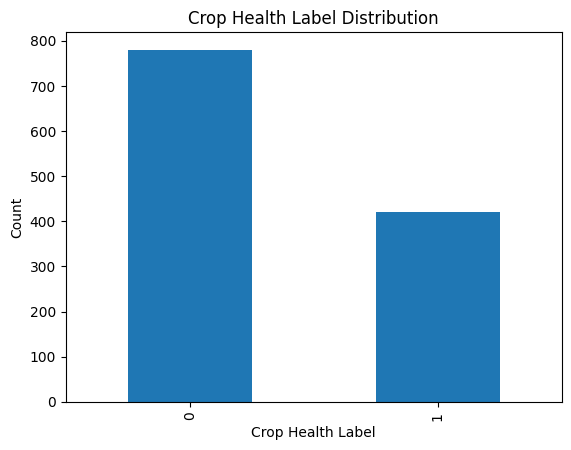

In [ ]:
pd.Series(y).value_counts().plot(kind="bar")
plt.title("Crop Health Label Distribution")
plt.xlabel("Crop Health Label")
plt.ylabel("Count")

##  Train test split
Dataset is split into training and testing sets to evaluate performance on unseen samples.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Task 2 - Machine Model Selection
Two models were evaluated: Logistic Regression and Random Forest.

Logistic Regression serves as a strong linear baseline model, while Random Forest captures nonlinear feature interactions. After evaluation, Logistic Regression achieved better ROC-AUC and F1-score on the test set.


### Logistic Regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

### Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

## Model Evaluation
Models are evaluated using precision, recall, F1-score, confusion matrix, and ROC-AUC.

In [ ]:
print("Logistic Regression:")
print("\nClassification Report\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\nRandom Forest:")
print("\nClaassification Report\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Logistic Regression:

Classification Report
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       156
           1       0.98      0.94      0.96        84

    accuracy                           0.97       240
   macro avg       0.97      0.96      0.97       240
weighted avg       0.97      0.97      0.97       240


Confusion Matrix:
 [[154   2]
 [  5  79]]

Random Forest:

Claassification Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       156
           1       0.93      0.92      0.92        84

    accuracy                           0.95       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.95      0.95      0.95       240

Confusion Matrix:
 [[150   6]
 [  7  77]]


Logistic Regression outperformed Random Forest on this dataset, indicating that crop health patterns are largely linearly separable in the vegetation index feature space.

### ROC Comparision

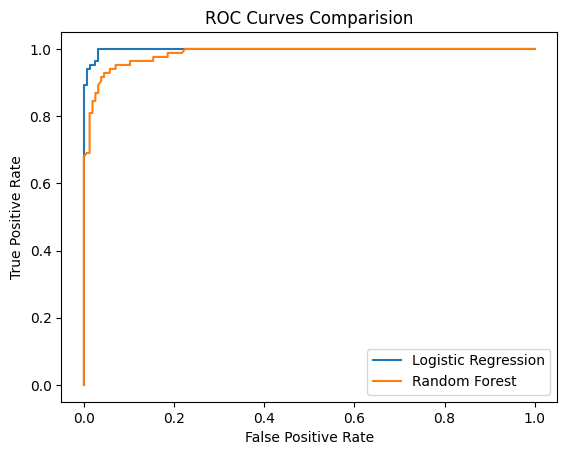

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparision")
plt.show()

### Final Evaluation

This indicates that the relationship between vegetation indices and crop health in this dataset is largely linear and separable. Therefore, Logistic Regression was selected as the final model.

### Feature Importance
Logistic Regression coefficients indicate how strongly each vegetation index influences crop health prediction. Features with larger coefficient magnitude have greater impact on the model decision.

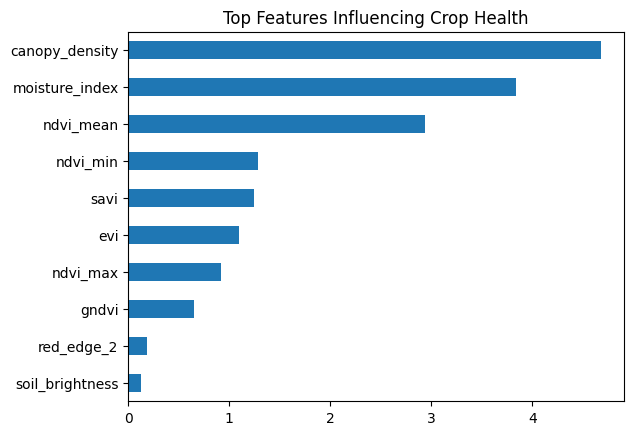

In [ ]:
coef = pd.Series(lr.coef_[0], index=X.columns)
coef_sorted = coef.abs().sort_values()

coef_sorted.tail(10).plot(kind="barh")
plt.title("Top Features Influencing Crop Health")
plt.show()

## Task 3 - Spatial Analysis & Visualization
The final model produces a probability score indicating crop stress risk for each observation.

In [ ]:
df["stress_risk"] = lr.predict_proba(scaler.transform(X))[:, 1]

### Spatial Stress Heatmap

Stress probabilities were aggregated by spatial grid coordinates (grid_x, grid_y) to generate a field-level stress heatmap. This visualization helps identify high-risk crop zones for targeted drone inspection.

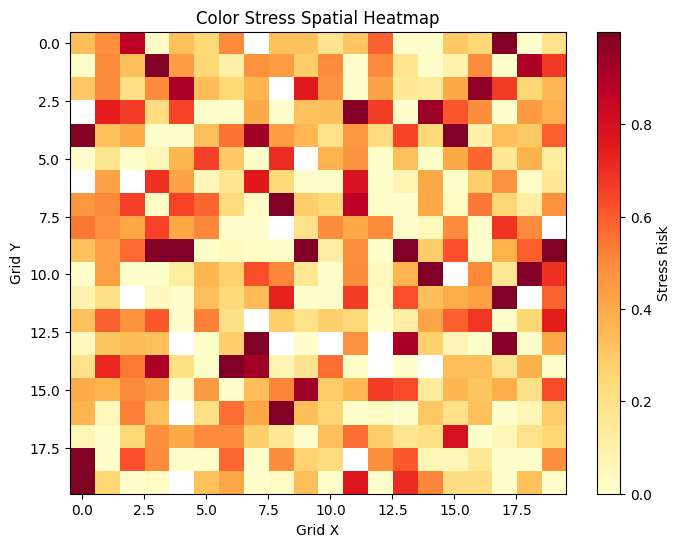

In [ ]:
heatmap = df.pivot_table(
    index="grid_y",
    columns="grid_x",
    values="stress_risk",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
plt.imshow(heatmap, aspect='auto', cmap='YlOrRd')
plt.colorbar(label="Stress Risk")
plt.title("Color Stress Spatial Heatmap")
plt.xlabel("Grid X")
plt.ylabel("Grid Y")
plt.show()

*Note: Some grid cells appear empty due to missing spatial observations, which reflects partial drone coverage and is common in real-world remote sensing.*

## Task 4 — Drone & Agronomy Interpretation

Based on the spatial stress heatmap, drone inspection should be prioritized according to stress severity. High-stress tiles should be inspected first using low-altitude drone flights for detailed analysis. Medium-stress areas should be revisited after irrigation or nutrient intervention. Low-stress regions can be monitored less frequently to optimize drone battery usage.

From an agronomy perspective, these stress hotspots enable targeted irrigation, fertilizer application, and pest inspection, supporting precision agriculture practices.

## Task 5 — Reflection and Improvements

While the model effectively predicts crop health using vegetation indices, several limitations exist. The dataset represents a single time snapshot and does not capture crop growth trends over time. Environmental factors such as weather conditions and soil nutrients are also not included. Additionally, sensor noise and lighting variations may affect vegetation index values.

Future improvements include integrating time-series drone data, weather and soil sensor information, and field-level ground truth validation to improve model robustness and real-world applicability.